In [1]:
import cv2               #for image read, flip, crop etc
import csv               #for csv file operation
import numpy as np       #for numpy array operation
import os                #for directory operation
import sklearn           #for yield, util etc
from sklearn.model_selection import train_test_split    # split train test data

#for model
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def getRelativeImagePath(dataPath, line):
    """
    @description:      This module gets relative image path from absolution path
    @param line:       line read from driving log csv
    @return newLine:   new line with relative path
    @example input:    /Users/udacity/CarND-Behavioral-Cloning-P3/data/IMG/center_2017_12_02_17_49_38_331.jpg
    @example output:   ./data/IMG/center_2017_12_02_17_49_38_331.jpg
    """
    source_path = line
    filename = source_path.split('/')[-1]
    newLine = dataPath +'/IMG/'+filename.strip()
    return newLine

In [3]:
def getLinesFromDrivingLogs(dataPath, skipHeader=False):
    """
    @description:      This module get list of lines from driving_log.csv
    @param dataPath:   data path where data is stored
    @param skipHeader: default false, true to skip header in csv
    @return:           array of lines
    """
    lines = []
    with open(dataPath + '/driving_log.csv') as csvFile:
        reader = csv.reader(csvFile)
        if skipHeader:
            next(reader, None)
        for line in reader:
            lines.append(line)
    return lines

In [4]:
def getImages(dataPath):
    """
    @description:     This module gets center, left, right and 
                      total measurement(stearing) using driving log csv    
    @param dataPath:  data path where data is stored
    @return:          array of center, left, right path and measurement(stearing)
    """
    directories = [x[0] for x in os.walk(dataPath)]
    dataDirectories = list(filter(lambda directory: os.path.isfile(directory + '/driving_log.csv'), directories))
    centerTotal = []
    leftTotal = []
    rightTotal = []
    measurementTotal = []
    print(dataDirectories)
    for directory in dataDirectories:
        lines = getLinesFromDrivingLogs(directory)
        center = []
        left = []
        right = []
        measurements = []
        for line in lines:
            measurements.append(float(line[3]))
            center.append(getRelativeImagePath(dataPath,line[0]))
            left.append(getRelativeImagePath(dataPath,line[1]))
            right.append(getRelativeImagePath(dataPath,line[2]))
        centerTotal.extend(center)
        leftTotal.extend(left)
        rightTotal.extend(right)
        measurementTotal.extend(measurements)

    return (centerTotal, leftTotal, rightTotal, measurementTotal)

In [5]:
def combineImagesAndMeasurementsCorrection(center, left, right, measurement, correction):
    """
    @description: combine image paths from center, left, right using correction
    @center:      center image path
    @left:        left image path
    @right:       right image path
    @return:      array of imagePath and measurements
    """
    imagePaths = []
    imagePaths.extend(center)
    imagePaths.extend(left)
    imagePaths.extend(right)
    measurements = []
    measurements.extend(measurement)
    measurements.extend([x + correction for x in measurement])
    measurements.extend([x - correction for x in measurement])
    return (imagePaths, measurements)

In [6]:
def generator(samples, batch_size=32):
    """
    @description:      generates required images and measurement 
                       using sample(training/validation) in batches of batch size
    @param samples:    list of pairs containing imagePath and measuremnet
    @param batch_size: batch size to generate data, default is 32 
    """
    num_samples = len(samples)
    while 1: # Loops forever, generator never ends
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:
                originalImage = cv2.imread(imagePath)
                image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
                images.append(image)
                angles.append(measurement)
                # Data augment: Flipping images
                images.append(cv2.flip(image,1))
                angles.append(measurement*-1.0)

            # Data augment: trim image to only see section with road
            inputs = np.array(images)
            outputs = np.array(angles)
            yield sklearn.utils.shuffle(inputs, outputs)

In [7]:
def getNvidiaModel():
    """
    @description: NVIDIA CNN model for keras 1
    """
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

In [8]:
# Reading images.
centerPaths, leftPaths, rightPaths, measurements = getImages('data')
imagePaths, measurements = combineImagesAndMeasurementsCorrection(centerPaths, leftPaths, rightPaths, measurements, 0.2)
print('Total Images: {}'.format( len(imagePaths)))

['data']
Total Images: 37236


In [9]:
# Splitting samples into training and validation samples
samples = list(zip(imagePaths, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

Train samples: 29788
Validation samples: 7448


In [10]:
# Creating train and validation generators.
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [11]:
# Creating Model
model = getNvidiaModel()

# Compiling and training the model
model.compile(loss='mse', optimizer='adam')
 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [17]:
history = model.fit_generator(train_generator, samples_per_epoch= \
                 len(train_samples) , validation_data=validation_generator, \
                 nb_val_samples=len(validation_samples), nb_epoch=3, verbose=1)
    
model.save('model.h5')

Epoch 1/3
29752/29788 [============================>.] - ETA: 0s - loss: 0.0637

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


29816/29788 [==============================] - 876s - loss: 0.0637 - val_loss: 0.0573
Epoch 2/3
29824/29788 [==============================] - 728s - loss: 0.0590 - val_loss: 0.0557
Epoch 3/3
29816/29788 [==============================] - 749s - loss: 0.0592 - val_loss: 0.0540


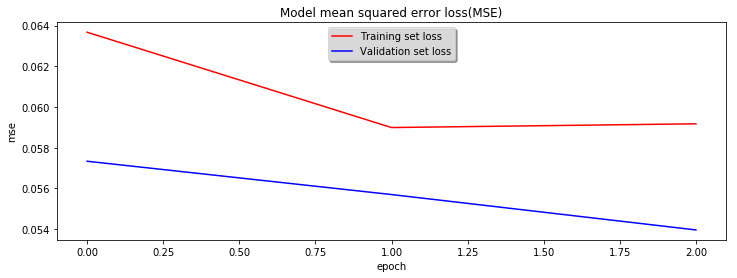

In [18]:
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(history.history['loss'], color='red', label='Training set loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation set loss')
plt.title('Model mean squared error loss(MSE)')
plt.ylabel('mse')
plt.xlabel('epoch')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')